In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

In [ ]:
import os
import random
import tensorflow as tf

def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

## 데이터 로드 및 전처리

In [ ]:
train_data = pd.read_csv("./train_total.csv", index_col = 0)
test_data = pd.read_csv("./test_total.csv", index_col = 0)
val_data = pd.read_csv("./val_total.csv", index_col = 0)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9507 entries, 0 to 9506
Data columns (total 52 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   EMAIL                              9507 non-null   object 
 1   activity_day_start                 9507 non-null   object 
 2   activity_class_5min_adj            9507 non-null   object 
 3   activity_met_5min_df_adj           9507 non-null   object 
 4   sleep_hr_5min_adj                  9507 non-null   object 
 5   sleep_hypnogram_5min_adj           9507 non-null   object 
 6   sleep_rmssd_5min_adj               9507 non-null   object 
 7   activity_average_met               9507 non-null   float64
 8   activity_cal_active                9507 non-null   int64  
 9   activity_cal_total                 9507 non-null   int64  
 10  activity_daily_movement            9507 non-null   int64  
 11  activity_high                      9507 non-null   int64  
 1

In [ ]:
drop_act_col = train_data.columns[7:-1].tolist()
drop_act_col

['activity_average_met',
 'activity_cal_active',
 'activity_cal_total',
 'activity_daily_movement',
 'activity_high',
 'activity_inactive',
 'activity_low',
 'activity_medium',
 'activity_met_min_high',
 'activity_met_min_inactive',
 'activity_met_min_low',
 'activity_met_min_medium',
 'activity_rest',
 'activity_score',
 'activity_score_meet_daily_targets',
 'activity_score_move_every_hour',
 'activity_score_recovery_time',
 'activity_score_stay_active',
 'activity_score_training_frequency',
 'activity_score_training_volume',
 'activity_steps',
 'activity_total',
 'sleep_awake',
 'sleep_breath_average',
 'sleep_deep',
 'sleep_duration',
 'sleep_efficiency',
 'sleep_hr_average',
 'sleep_hr_lowest',
 'sleep_light',
 'sleep_onset_latency',
 'sleep_rem',
 'sleep_restless',
 'sleep_rmssd',
 'sleep_score',
 'sleep_score_alignment',
 'sleep_score_deep',
 'sleep_score_disturbances',
 'sleep_score_efficiency',
 'sleep_score_latency',
 'sleep_score_rem',
 'sleep_score_total',
 'sleep_temperatur

In [ ]:
train_data.drop(columns = drop_act_col, inplace = True)
test_data.drop(columns = drop_act_col, inplace = True)
val_data.drop(columns = drop_act_col, inplace = True)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9507 entries, 0 to 9506
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   EMAIL                     9507 non-null   object
 1   activity_day_start        9507 non-null   object
 2   activity_class_5min_adj   9507 non-null   object
 3   activity_met_5min_df_adj  9507 non-null   object
 4   sleep_hr_5min_adj         9507 non-null   object
 5   sleep_hypnogram_5min_adj  9507 non-null   object
 6   sleep_rmssd_5min_adj      9507 non-null   object
 7   DIAG_NM                   9507 non-null   object
dtypes: object(8)
memory usage: 668.5+ KB


In [ ]:
train_data['DIAG_NM'] = train_data['DIAG_NM'].apply(lambda x: 'MCI' if x == 'Dem' else x)
test_data['DIAG_NM'] = test_data['DIAG_NM'].apply(lambda x: 'MCI' if x == 'Dem' else x)
val_data['DIAG_NM'] = val_data['DIAG_NM'].apply(lambda x: 'MCI' if x == 'Dem' else x)

'''
train_data = train_data[train_data['DIAG_NM'] != 'Dem'].reset_index(drop=True)
test_data = test_data[test_data['DIAG_NM'] != 'Dem'].reset_index(drop=True)
val_data = val_data[val_data['DIAG_NM'] != 'Dem'].reset_index(drop=True)
'''

"\ntrain_data = train_data[train_data['DIAG_NM'] != 'Dem'].reset_index(drop=True)\ntest_data = test_data[test_data['DIAG_NM'] != 'Dem'].reset_index(drop=True)\nval_data = val_data[val_data['DIAG_NM'] != 'Dem'].reset_index(drop=True)\n"

### 라벨 인코딩 (DIAG_NM이 CN, MCI 등의 문자열이므로 변환)

In [ ]:
le = LabelEncoder()
le.classes_ = np.array(['CN', 'MCI'])  # le.classes_로 원하는 순서를 설정할 수 있다

train_data['DIAG_NM'] = le.transform(train_data['DIAG_NM'])
test_data['DIAG_NM'] = le.transform(test_data['DIAG_NM'])
val_data['DIAG_NM'] = le.transform(val_data['DIAG_NM'])


### 문자열 -> 수치형 데이터로 전환

In [ ]:
import ast

# 문자열을 리스트로 변환하고 각 요소를 숫자로 변환하는 함수
def convert_str_to_numeric_list(x):
    if isinstance(x, str):  # 문자열인 경우
        try:
            # 문자열을 리스트로 변환 후 각 요소를 숫자로 변환
            return [float(i) for i in ast.literal_eval(x)]  # 실수로 변환하고 다시 리스트 만들기
        except:
            return []  # 변환 실패 시 빈 리스트 반환
    return x  # 이미 리스트인 경우 그대로 반환

In [ ]:
# 변수 타입 확인
def check_data_types(df):
    feature_columns = ['activity_class_5min_adj', 'activity_met_5min_df_adj',
                        'sleep_hr_5min_adj',
                        'sleep_hypnogram_5min_adj', 'sleep_rmssd_5min_adj']
    for col in feature_columns:
        print(f"Checking types in column: {col}")
        # 리스트 내부의 데이터 타입을 확인
        types = df[col].apply(lambda x: type(x) if isinstance(x, object) else None).unique()
        print(f"Unique types in column {col}: {types}")

In [ ]:
feature_columns = ['activity_class_5min_adj', 'activity_met_5min_df_adj',
                    'sleep_hr_5min_adj',
                        'sleep_hypnogram_5min_adj', 'sleep_rmssd_5min_adj']

train_data[feature_columns] = train_data[feature_columns].applymap(convert_str_to_numeric_list)
# 데이터 타입 확인
check_data_types(train_data)

<ipython-input-21-bc0efac0553e>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data[feature_columns] = train_data[feature_columns].applymap(convert_str_to_numeric_list)


Checking types in column: activity_class_5min_adj
Unique types in column activity_class_5min_adj: [<class 'list'>]
Checking types in column: activity_met_5min_df_adj
Unique types in column activity_met_5min_df_adj: [<class 'list'>]
Checking types in column: sleep_hr_5min_adj
Unique types in column sleep_hr_5min_adj: [<class 'list'>]
Checking types in column: sleep_hypnogram_5min_adj
Unique types in column sleep_hypnogram_5min_adj: [<class 'list'>]
Checking types in column: sleep_rmssd_5min_adj
Unique types in column sleep_rmssd_5min_adj: [<class 'list'>]


In [ ]:
test_data[feature_columns] = test_data[feature_columns].applymap(convert_str_to_numeric_list)
check_data_types(test_data)

<ipython-input-22-69300446a7e4>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_data[feature_columns] = test_data[feature_columns].applymap(convert_str_to_numeric_list)


Checking types in column: activity_class_5min_adj
Unique types in column activity_class_5min_adj: [<class 'list'>]
Checking types in column: activity_met_5min_df_adj
Unique types in column activity_met_5min_df_adj: [<class 'list'>]
Checking types in column: sleep_hr_5min_adj
Unique types in column sleep_hr_5min_adj: [<class 'list'>]
Checking types in column: sleep_hypnogram_5min_adj
Unique types in column sleep_hypnogram_5min_adj: [<class 'list'>]
Checking types in column: sleep_rmssd_5min_adj
Unique types in column sleep_rmssd_5min_adj: [<class 'list'>]


In [ ]:
val_data[feature_columns] = val_data[feature_columns].applymap(convert_str_to_numeric_list)
check_data_types(val_data)

<ipython-input-23-1cf2834c50bf>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_data[feature_columns] = val_data[feature_columns].applymap(convert_str_to_numeric_list)


Checking types in column: activity_class_5min_adj
Unique types in column activity_class_5min_adj: [<class 'list'>]
Checking types in column: activity_met_5min_df_adj
Unique types in column activity_met_5min_df_adj: [<class 'list'>]
Checking types in column: sleep_hr_5min_adj
Unique types in column sleep_hr_5min_adj: [<class 'list'>]
Checking types in column: sleep_hypnogram_5min_adj
Unique types in column sleep_hypnogram_5min_adj: [<class 'list'>]
Checking types in column: sleep_rmssd_5min_adj
Unique types in column sleep_rmssd_5min_adj: [<class 'list'>]


### 원하는 시퀀스 길이 설정 및 입력값 준비

In [ ]:
def prepare_sequences(df, sequence_length, step = 1):
    sequences, labels = [], []
    log_features = ['sleep_hr_5min_adj',
                        'sleep_hypnogram_5min_adj', 'sleep_rmssd_5min_adj']
    general_features = df.columns[7:-1]

    # 리스트 데이터(예: 로그 데이터)를 개별 숫자로 변환
    expanded_features = []
    for col in log_features:
        expanded_features.extend([f"{col}_{i}" for i in range(288)])  # 288개 요소를 개별 컬럼으로 확장

    # 로그 데이터 변수를 개별 숫자로 변환 (리스트 형태를 수치형 배열로 변환)
    expanded_data = []
    for row in df[log_features].values:
        expanded_row = []
        for item in row:
            if isinstance(item, list):  # 리스트가 있는 경우
                expanded_row.extend(item)  # 288개의 값으로 확장
            else:
                expanded_row.append(item)  # 리스트가 아닌 경우 그대로 추가
        expanded_data.append(expanded_row)

    # 변환된 데이터를 DataFrame으로 만들기
    expanded_df = pd.DataFrame(expanded_data, columns=expanded_features)

    # 일반 변수 추가
    expanded_df = pd.concat([expanded_df, df[general_features].reset_index(drop=True)], axis=1)

    # MinMax 스케일링 적용
    scaler = MinMaxScaler()
    expanded_df = pd.DataFrame(scaler.fit_transform(expanded_df), columns=expanded_df.columns)

    # 참가자별로 시퀀스 데이터 생성
    for _, group in df.groupby('EMAIL'):
        group_expanded_df = expanded_df.loc[group.index]  # 해당 참가자의 데이터만 사용

        for i in range(0, len(group_expanded_df) - sequence_length, step): #슬라이딩 윈도우 방식 적용(step 조절)
            sequences.append(group_expanded_df.iloc[i:i+sequence_length].values)
            labels.append(group['DIAG_NM'].iloc[i+sequence_length])

    return np.array(sequences, dtype=np.float32), np.array(labels)

In [ ]:
sequence_length = 7  # 원하는 값으로 조정 가능
step = 3
X_train, y_train = prepare_sequences(train_data, sequence_length, step)
X_test, y_test = prepare_sequences(test_data, sequence_length, step)
X_val, y_val = prepare_sequences(val_data, sequence_length, step)


In [ ]:
# 총 변수 864 = 288*3
X_train.shape, y_train.shape

((2891, 7, 864), (2891,))

## LSTM 모델 정의

In [ ]:
model = Sequential([
    LSTM(128, activation='relu',  return_sequences=True, kernel_regularizer=l2(0.01),
         input_shape=(sequence_length, X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(16, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 모델 컴파일

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy

def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        bce = binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = (1 - p_t) ** gamma
        return K.mean(alpha_factor * modulating_factor * bce)
    return loss

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=Adam(learning_rate=0.0005), loss = focal_loss(), metrics=['accuracy'])


### 모델 학습

In [ ]:
# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
class_weights = {0: 0.5, 1: 3.0}

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32,
          callbacks=[early_stopping], class_weight = class_weights, shuffle=False)
#shuffle=True는 배치를 만들 때 데이터셋 전체를 랜덤하게 섞는다. 랜덤 데이터에서 배치 사이즈만큼 샘플을 뽑는다.
#시계열 데이터에서는 shuffle=False로 원래 데이터 순서를 유지하는 것이 필수

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.5150 - loss: 6.1334 - val_accuracy: 0.6336 - val_loss: 2.2996
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.5525 - loss: 1.9050 - val_accuracy: 0.6845 - val_loss: 1.0107
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.5546 - loss: 0.9372 - val_accuracy: 0.7379 - val_loss: 0.5997
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.5565 - loss: 0.5817 - val_accuracy: 0.6692 - val_loss: 0.3840
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5583 - loss: 0.4079 - val_accuracy: 0.6489 - val_loss: 0.2839
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.5594 - loss: 0.3075 - val_accuracy: 0.6565 - val_loss: 0.2156
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5711 - loss: 0.2482 - val_accuracy: 0.7023 - val_loss: 0.1647
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5696 - loss: 0.2087 - val_accuracy: 0.7455 - 

### 예측 결과 그래프

91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


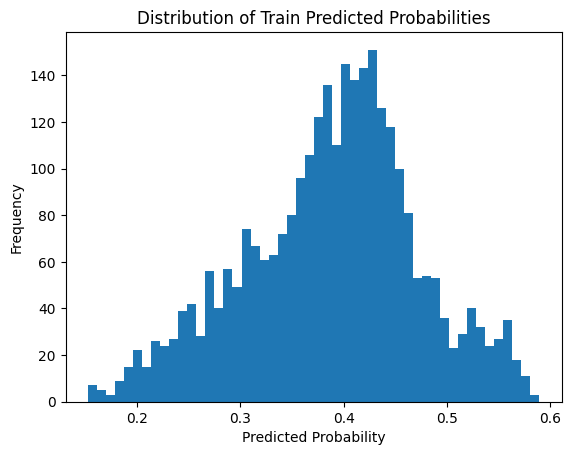

In [ ]:
import matplotlib.pyplot as plt

y_train_probs = model.predict(X_train)
plt.hist(y_train_probs, bins=50)
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Train Predicted Probabilities")
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


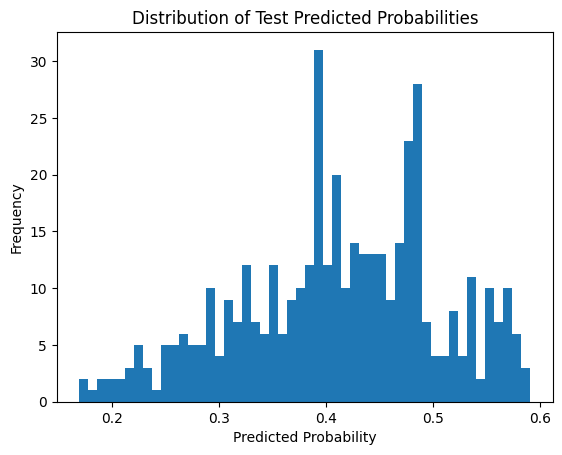

In [ ]:
y_train_probs = model.predict(X_test)
plt.hist(y_train_probs, bins=50)
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Test Predicted Probabilities")
plt.show()

In [ ]:
# sigmoid 출력 변환
y_train_pred = (model.predict(X_train) > 0.4).astype(int)
y_val_pred = (model.predict(X_val) > 0.4).astype(int)
y_test_pred = (model.predict(X_test) > 0.4).astype(int)

91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


### 결과 출력

In [ ]:
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

[[1093  737]
 [ 403  658]]
              precision    recall  f1-score   support

           0       0.73      0.60      0.66      1830
           1       0.47      0.62      0.54      1061

    accuracy                           0.61      2891
   macro avg       0.60      0.61      0.60      2891
weighted avg       0.64      0.61      0.61      2891



In [ ]:
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

[[187  62]
 [ 61  83]]
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       249
           1       0.57      0.58      0.57       144

    accuracy                           0.69       393
   macro avg       0.66      0.66      0.66       393
weighted avg       0.69      0.69      0.69       393



In [ ]:
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[126 149]
 [ 59  93]]
              precision    recall  f1-score   support

           0       0.68      0.46      0.55       275
           1       0.38      0.61      0.47       152

    accuracy                           0.51       427
   macro avg       0.53      0.54      0.51       427
weighted avg       0.58      0.51      0.52       427



### 참가자별 결과 저장

In [ ]:
def per_person_pred(raw_data, input_data, pred_threshold=0.5, person_threshold=0.5):
    # 1. 예측 확률
    y_probs = model.predict(input_data).flatten()  # 예측 확률값 (N,)
    y_preds = (y_probs > pred_threshold).astype(int)

    print("input_data shape:", input_data.shape)
    print("model input shape:", model.input_shape)

    # 2. 각 시퀀스가 어떤 사람에 해당하는지 매핑
    sequence_person_ids = []
    for _, group in raw_data.groupby("EMAIL"):
        person_id = group["EMAIL"].iloc[0]
        for i in range(0, len(group) - sequence_length, step):
            sequence_person_ids.append(person_id)

    # 3. DataFrame 구성
    df_preds = pd.DataFrame({"EMAIL": sequence_person_ids, "prediction": y_preds})

    # 4. 사람별 평균 예측값(행별 0 혹은 1)의 평균이 threshold을 넘으면 1로 판정(최종 클래스 결정)
    person_final_preds = df_preds.groupby("EMAIL")["prediction"].mean()
    test_person_predictions = (person_final_preds >= person_threshold).astype(int)

    # 5. 실제값과 비교
    ground_truth = raw_data.groupby("EMAIL")["DIAG_NM"].mean().astype(int)
    results_df = pd.DataFrame({
        "EMAIL": ground_truth.index,
        "true": ground_truth.values,
        "pred": test_person_predictions.values
    })

    return results_df

In [ ]:
train_result_df = per_person_pred(train_data, X_train, pred_threshold=0.4, person_threshold=0.5)

print(confusion_matrix(train_result_df["true"], train_result_df["pred"]))
print(classification_report(train_result_df["true"], train_result_df["pred"]))

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
input_data shape: (2891, 7, 864)
model input shape: (None, 7, 864)
[[52 37]
 [16 33]]
              precision    recall  f1-score   support

           0       0.76      0.58      0.66        89
           1       0.47      0.67      0.55        49

    accuracy                           0.62       138
   macro avg       0.62      0.63      0.61       138
weighted avg       0.66      0.62      0.62       138



In [ ]:
test_result_df = per_person_pred(test_data, X_test, pred_threshold=0.4, person_threshold=0.5)

print(confusion_matrix(test_result_df["true"], test_result_df["pred"]))
print(classification_report(test_result_df["true"], test_result_df["pred"]))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
input_data shape: (427, 7, 864)
model input shape: (None, 7, 864)
[[6 5]
 [2 5]]
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.50      0.71      0.59         7

    accuracy                           0.61        18
   macro avg       0.62      0.63      0.61        18
weighted avg       0.65      0.61      0.61        18

